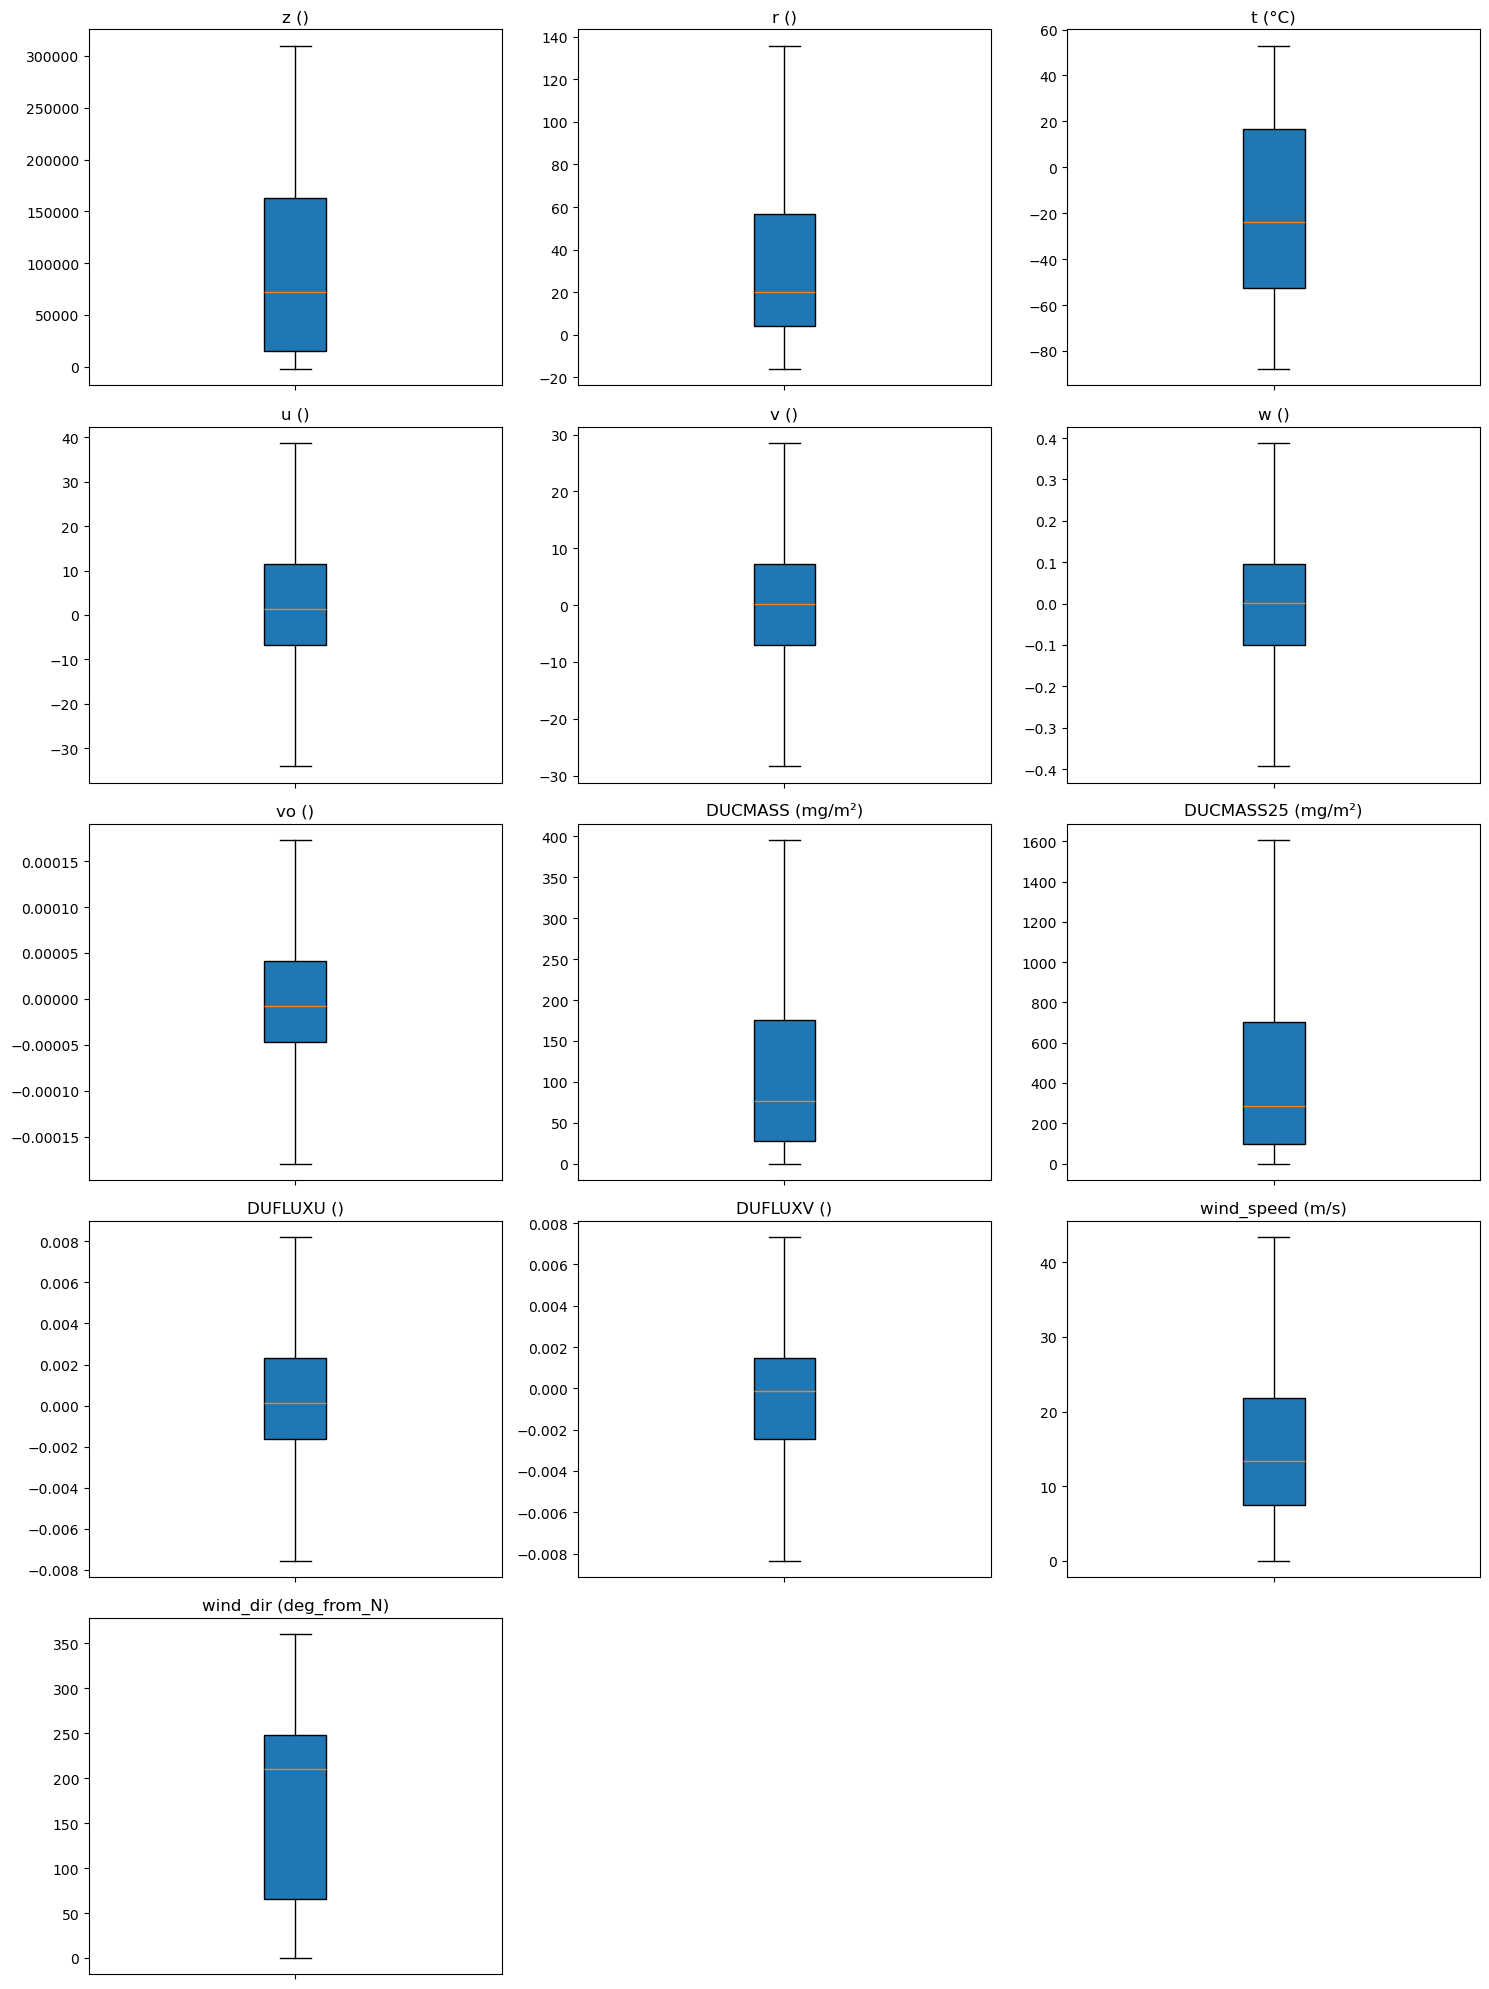

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import math

# ------------------------- CONFIGURATION -------------------------
base_path = r"Z:\Thesis\Data\ML_Data\AP_training2"
# For upper‐atmospheric data, we assume the same file naming convention.
output_dir = r"Z:\Thesis\Data\test\DustCast\UA\DC_v0063\boxplots"
os.makedirs(output_dir, exist_ok=True)

train_years = [
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000,
    2013, 2014, 2015, 2016, 2017, 2018, 2019, 
    2020, 2021, 2022, 2023
]

countries = [
    "Yemen", 
    "Bahrain", 
    "Kuwait", 
    "Oman", 
    "Qatar", 
    "Saudi_Arabia", 
    "United_Arab_Emirates"
]

# ------------------------- DATA LOADING & COMBINING -------------------------
all_dfs = []
for country in countries:
    for yr in train_years:
        file_path = os.path.join(
            base_path, 
            str(yr), 
            f"{country}_{yr}_pressure_monthly_stats_merged.parquet"
        )
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path)
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"File does not exist: {file_path}")

if not all_dfs:
    raise ValueError("No data files loaded!")

df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------- DATA PREPROCESSING -------------------------
# Convert all columns to numeric when possible.
for col in df_all.columns:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# ------------------------- DERIVED VARIABLES -------------------------
# Compute wind speed and direction for the mean components.
if "u_mean" in df_all.columns and "v_mean" in df_all.columns:
    wind_speed_mean = np.sqrt(df_all["u_mean"]**2 + df_all["v_mean"]**2)
    theta_deg_mean = np.degrees(np.arctan2(df_all["v_mean"], df_all["u_mean"]))
    wind_dir_mean = (270.0 - theta_deg_mean) % 360.0
    df_all["wind_speed_mean"] = wind_speed_mean
    df_all["wind_dir_mean"] = wind_dir_mean

# Compute wind speed and direction for the minimum components.
if "u_min" in df_all.columns and "v_min" in df_all.columns:
    wind_speed_min = np.sqrt(df_all["u_min"]**2 + df_all["v_min"]**2)
    theta_deg_min = np.degrees(np.arctan2(df_all["v_min"], df_all["u_min"]))
    wind_dir_min = (270.0 - theta_deg_min) % 360.0
    df_all["wind_speed_min"] = wind_speed_min
    df_all["wind_dir_min"] = wind_dir_min

# Compute wind speed and direction for the maximum components.
if "u_max" in df_all.columns and "v_max" in df_all.columns:
    wind_speed_max = np.sqrt(df_all["u_max"]**2 + df_all["v_max"]**2)
    theta_deg_max = np.degrees(np.arctan2(df_all["v_max"], df_all["u_max"]))
    wind_dir_max = (270.0 - theta_deg_max) % 360.0
    df_all["wind_speed_max"] = wind_speed_max
    df_all["wind_dir_max"] = wind_dir_max


# ------------------------- GROUP COLUMNS BY BASE NAME -------------------------
# We want to group together columns that share the same base if they end with _min, _max, or _mean.
grouped_columns = {}
for col in df_all.columns:
    for suffix in ["_min", "_max", "_mean"]:
        if col.endswith(suffix):
            base = col[:-len(suffix)]
            if base not in grouped_columns:
                grouped_columns[base] = []
            grouped_columns[base].append(col)
            break

# ------------------------- COMBINE THE GROUPS & APPLY UNIT CONVERSIONS -------------------------
# Here we combine the values from all columns that share the same base.
# Then, apply unit conversions as needed.
variable_series = {}

for base, cols in grouped_columns.items():
    # Combine all values from the grouped columns into one series.
    combined = pd.concat([df_all[c].dropna() for c in cols])
    
    # Apply unit conversions based on the base name.
    # Temperature: if the base is "t" (coming from t_min, t_max, t_mean), convert from Kelvin to °C.
    if base == "t":
        combined = combined - 273.15
    # Dust mass: if base (or part of it) contains "ducmass" (or "ducmass25"), convert from kg/m³ to mg/m².
    if "ducmass" in base.lower():
        combined = combined * 1e6  # 1 kg = 1e6 mg
    # Pressure: if the base is "msl", convert from Pa to hPa.
    if base.lower() == "msl":
        combined = combined / 100
    # (You can add additional conversion rules here as needed.)
    
    variable_series[base] = combined

# Also, if there are any numeric columns that do not follow the _min/_max/_mean pattern
# (or if you want to include derived variables like wind_speed, wind_dir), add them separately.
for var in ["wind_speed", "wind_dir"]:
    if var in df_all.columns:
        variable_series[var] = df_all[var].dropna()

# ------------------------- DEFINE UNITS FOR VARIABLES -------------------------
variable_units = {}
for base in variable_series.keys():
    if base == "t":
        variable_units[base] = "°C"
    elif "ducmass" in base.lower():
        variable_units[base] = "mg/m²"
    elif base.lower() == "msl":
        variable_units[base] = "hPa"
    elif base in ["wind_speed"]:
        variable_units[base] = "m/s"
    elif base in ["wind_dir"]:
        variable_units[base] = "deg_from_N"
    else:
        # For all other variables, you can leave the unit empty or set a default.
        variable_units[base] = ""

# ------------------------- FACET WRAPPED BOX PLOTS -------------------------
n_vars = len(variable_series)
ncols = 3
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axes = np.array(axes).reshape(-1)

for i, (base, series) in enumerate(variable_series.items()):
    ax = axes[i]
    ax.boxplot(series, notch=False, patch_artist=True, showfliers=False)
    unit = variable_units.get(base, "")
    ax.set_title(f"{base} ({unit})")
    ax.set_xticklabels([])
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
facet_save_path = os.path.join(output_dir, "facet_boxplots_upper_atmo_grouped.png")
plt.savefig(facet_save_path)
plt.show()
plt.close(fig)

# ------------------------- SUMMARY STATISTICS -------------------------
# Calculate mean, max, min, and standard deviation for each base variable.
summary_data = []
for base, series in variable_series.items():
    summary_data.append({
        "Variable": base,
        "Mean": series.mean(),
        "Max": series.max(),
        "Min": series.min(),
        "Std": series.std(),
        "Units": variable_units.get(base, "")
    })

summary_df = pd.DataFrame(summary_data)
summary_csv_path = os.path.join(output_dir, "summary_statistics_upper_atmo_grouped.csv")
summary_df.to_csv(summary_csv_path, index=False)
